# Language Detection

In [71]:
from pathlib import Path
import glob
import os
import pandas as pd

In [72]:
NAMES_PATH = Path('data/names')

In [73]:
for name_file in NAMES_PATH.glob('*.txt'):
    print(name_file)

data\names\Arabic.txt
data\names\Chinese.txt
data\names\Czech.txt
data\names\Dutch.txt
data\names\English.txt
data\names\French.txt
data\names\German.txt
data\names\Greek.txt
data\names\Irish.txt
data\names\Italian.txt
data\names\Japanese.txt
data\names\Korean.txt
data\names\Polish.txt
data\names\Portuguese.txt
data\names\Russian.txt
data\names\Scottish.txt
data\names\Spanish.txt
data\names\Vietnamese.txt


In [74]:
from languageutils import *

## Load the Language Names Files

In [75]:
name_files = NAMES_PATH.glob('*.txt')

language_to_names = { file.name[:-4] : readLines(file) 
                                        for file in name_files }
languages = list(language_to_names.keys())
n_languages = len(language_to_names)

#### Langage Dictionary

In [76]:
languages

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

In [77]:
language_to_names['English'][10]

'Acton'

In [78]:
import random
language_summary = pd.DataFrame([{'Language': k, 
                                  'Number of Names': len(v), 
                                  'Random Name': random.choice(v)} 
                                     for k,v in language_to_names.items()]).set_index('Language')
language_summary.sort_values(['Number of Names'], ascending=False)

,Number of Names,Random Name
Language,,
Russian,9408,Mahrov
English,3668,Inman
Arabic,2000,Sabbagh
Japanese,991,Tomimoto
German,724,Wyman
Italian,709,Tumicelli
Czech,519,Hana
Spanish,298,Medina
Dutch,297,Seghers


### Turning Names into Tensors

In [79]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J').size())

print(lineToTensor('Jones').size())

torch.Size([1, 57])
torch.Size([5, 1, 57])


## Creating the Network

In [80]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_languages)

In [81]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

In [82]:
f'{n_letters} letters plus {n_hidden} features = input size of {n_letters + n_hidden}'

'57 letters plus 128 features = input size of 185'

In [83]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [84]:
output, next_hidden

(tensor([[-2.9364, -2.9501, -2.8934, -2.8461, -2.9653, -2.7807, -2.8509,
          -2.8988, -2.8595, -2.8846, -2.9719, -2.8463, -2.8996, -2.8960,
          -2.8425, -2.8792, -2.9299, -2.9162]]),
 tensor([[ 0.0145, -0.0463, -0.0362, -0.0221,  0.0181,  0.0176,  0.0062,
           0.0267, -0.0753, -0.0240,  0.0018,  0.1030, -0.0543,  0.0966,
           0.0296,  0.0169,  0.0681,  0.0770, -0.0294,  0.0894,  0.0362,
          -0.0124,  0.0254, -0.0182,  0.0505,  0.0740, -0.0102,  0.0720,
           0.0199,  0.0913,  0.0437, -0.0167, -0.1178,  0.0662,  0.0842,
           0.0268,  0.0653, -0.0196,  0.0705, -0.0168, -0.1107,  0.1353,
           0.0051,  0.0178, -0.0787,  0.1410,  0.0372, -0.0815, -0.0223,
           0.0888, -0.0121, -0.0866, -0.1134,  0.0148,  0.0561,  0.0173,
          -0.0320, -0.0195, -0.0839,  0.0820, -0.0418, -0.0760,  0.0066,
          -0.0392, -0.0406, -0.0163,  0.0009,  0.0468,  0.0008, -0.0882,
          -0.0081, -0.0641,  0.0087, -0.0283,  0.1068,  0.0152,  0.1157,
  

In [85]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
output, next_hidden

(tensor([[-2.9364, -2.9501, -2.8934, -2.8461, -2.9653, -2.7807, -2.8509,
          -2.8988, -2.8595, -2.8846, -2.9719, -2.8463, -2.8996, -2.8960,
          -2.8425, -2.8792, -2.9299, -2.9162]]),
 tensor([[ 0.0145, -0.0463, -0.0362, -0.0221,  0.0181,  0.0176,  0.0062,
           0.0267, -0.0753, -0.0240,  0.0018,  0.1030, -0.0543,  0.0966,
           0.0296,  0.0169,  0.0681,  0.0770, -0.0294,  0.0894,  0.0362,
          -0.0124,  0.0254, -0.0182,  0.0505,  0.0740, -0.0102,  0.0720,
           0.0199,  0.0913,  0.0437, -0.0167, -0.1178,  0.0662,  0.0842,
           0.0268,  0.0653, -0.0196,  0.0705, -0.0168, -0.1107,  0.1353,
           0.0051,  0.0178, -0.0787,  0.1410,  0.0372, -0.0815, -0.0223,
           0.0888, -0.0121, -0.0866, -0.1134,  0.0148,  0.0561,  0.0173,
          -0.0320, -0.0195, -0.0839,  0.0820, -0.0418, -0.0760,  0.0066,
          -0.0392, -0.0406, -0.0163,  0.0009,  0.0468,  0.0008, -0.0882,
          -0.0081, -0.0641,  0.0087, -0.0283,  0.1068,  0.0152,  0.1157,
  

In [86]:
output.shape

torch.Size([1, 18])

In [87]:
hidden.shape

torch.Size([1, 128])

## Training

In [88]:
def languageFromOutput(output):
    top_n, top_i = output.topk(1)
    language_i = top_i[0].item()
    return languages[language_i], language_i

print(languageFromOutput(output))

('French', 5)


In [89]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    language = randomChoice(languages)
    line = randomChoice(language_to_names[language])
    language_index = languages.index(language)
    language_tensor = torch.tensor([language_index], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return language, line, language_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Yue
category = Japanese / line = Modegi
category = Dutch / line = Maas
category = Italian / line = Adessi
category = Vietnamese / line = Do
category = French / line = St martin
category = Czech / line = Koliha
category = Japanese / line = Anami
category = Spanish / line = Zamorano
category = Japanese / line = Imoo


### Loss Functions

In [90]:
criterion = nn.NLLLoss()

In [91]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [92]:
import time
import math

n_iters = 60000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = languageFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 8% (0m 10s) 2.7165 Ursler / English ✗ (German)
10000 16% (0m 19s) 1.5306 Oh / Vietnamese ✗ (Korean)
15000 25% (0m 29s) 1.3609 Ma / Vietnamese ✓
20000 33% (0m 39s) 2.0078 Maneates / Dutch ✗ (Greek)
25000 41% (0m 49s) 2.0118 Allwood / French ✗ (English)
30000 50% (0m 58s) 1.1665 Shi / Korean ✗ (Chinese)
35000 58% (1m 7s) 3.0174 Croce / Scottish ✗ (Italian)
40000 66% (1m 17s) 1.1357 Campbell / Scottish ✓
45000 75% (1m 27s) 1.3021 Shuo / Korean ✗ (Chinese)
50000 83% (1m 40s) 2.0121 Littlewood / Greek ✗ (English)
55000 91% (1m 50s) 2.9110 Tomes / Dutch ✗ (Czech)
60000 100% (2m 0s) 1.2235 Yim / Korean ✗ (Chinese)


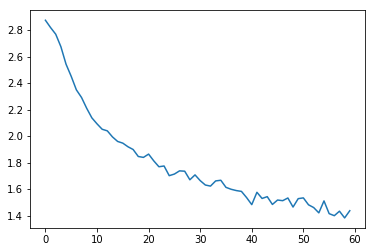

In [93]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

plt.figure()
plt.plot(all_losses)


In [126]:
rnn

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax()
)

## Evaluating the Results

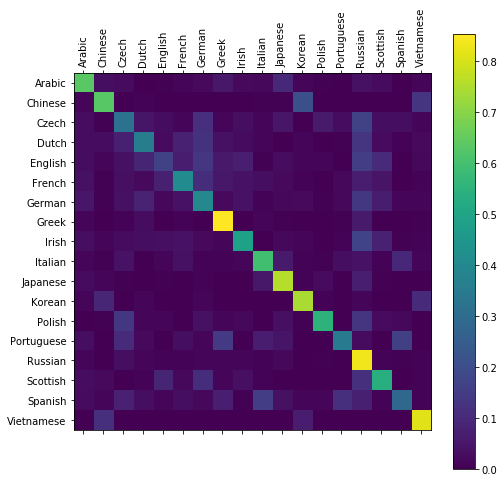

In [94]:
#Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_languages, n_languages)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = languageFromOutput(output)
    category_i = languages.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_languages):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

## Saving and reloading models

In [99]:
rnn_model_path = 'models/NameLanguageModel.rnn'
torch.save(rnn.state_dict(), rnn_model_path)


In [ ]:
rnn.load_state_dict(torch.load(rnn_model_path))

In [110]:
def predict_language(name):
    name_tensor = lineToTensor(name)
    output = evaluate(name_tensor)
    guess, guess_i = languageFromOutput(output)
    return guess


In [111]:
predict_language('Allen')

'English'

In [103]:
customer_data = pd.read_csv('data/CustomerData.csv')

In [105]:
customer_data.head(20)

,Person,City,Agency
0,Panousis,Ortizmouth,Cambridge Travel
1,Zhang,Isabelview,Cambridge Travel
2,Li,Daniellechester,Pegasus Vacations
3,Moreau,Daniellechester,Cambridge Travel
4,Jansen,Ortizmouth,Cambridge Travel
5,Novak,Isabelview,Magellan Stays
6,Van Dijk,South Cynthia,Magellan Stays
7,McCarthy,Andreaside,Pegasus Vacations
8,Fearghal,Erinfurt,Cambridge Travel
9,Williams,New Stephenborough,Cambridge Travel


In [116]:
lang = customer_data.Person.apply(predict_language)
customer_data['Language'] = lang

In [117]:
customer_data

,Person,City,Agency,Language
0,Panousis,Ortizmouth,Cambridge Travel,Greek
1,Zhang,Isabelview,Cambridge Travel,Vietnamese
2,Li,Daniellechester,Pegasus Vacations,Vietnamese
3,Moreau,Daniellechester,Cambridge Travel,French
4,Jansen,Ortizmouth,Cambridge Travel,Dutch
5,Novak,Isabelview,Magellan Stays,Polish
6,Van Dijk,South Cynthia,Magellan Stays,Polish
7,McCarthy,Andreaside,Pegasus Vacations,Irish
8,Fearghal,Erinfurt,Cambridge Travel,Irish
9,Williams,New Stephenborough,Cambridge Travel,Greek


In [119]:
customer_data.to_csv('data/CustomerDataWithLanguage.csv', index=False)

In [120]:
sum([ len(x) for k,x in language_to_names.items()])

20074

In [121]:
len(language_to_names['English'])

3668

In [125]:
pd.DataFrame([ (k, len(x)) for k,x in language_to_names.items()])

,0,1
0,Arabic,2000
1,Chinese,268
2,Czech,519
3,Dutch,297
4,English,3668
5,French,277
6,German,724
7,Greek,203
8,Irish,232
9,Italian,709
